# Reads 30min GPM IMERGE data

In [1]:
import os
from glob import glob

import datetime as dt
import earthpy as et
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.2)

In [2]:
westernUS = ['Colorado', 'California', 'Oregon', 'Washington']
state = westernUS[0]

In [3]:
# Read the GLC file
glc_file = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone', 
                        'landslide', 'nasa_global_landslide_catalog_point.csv')

glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') 
             & (glc['admin_division_name'] == state) 
             & (glc['landslide_trigger'] != 'freeze_thaw') 
             & (glc['landslide_trigger'] != 'snowfall_snowmelt') 
             & (glc['landslide_trigger'] != 'earthquake') 
             & (glc['landslide_trigger'] != 'leaking_pipe') 
             & (glc['landslide_trigger'] != 'no_apparent_trigger') 
             & (glc['landslide_trigger'] != 'other')              
             & (glc['landslide_trigger'] != 'unknown')
            ]
# convert to pandas datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date']).dt.strftime('%Y-%m-%d')
glc_co = glc_co.set_index('date').sort_index()
glc_co_gt2015 = glc_co[glc_co.index > '2015-04-01']

print(glc_co_gt2015.shape)
print(np.unique(glc_co_gt2015['landslide_trigger']))
print(np.unique(glc_co_gt2015['landslide_category']))
print(glc_co_gt2015.columns)
glc_co_gt2015.head()

(39, 31)
['continuous_rain' 'downpour' 'rain']
['debris_flow' 'landslide' 'mudslide' 'rock_fall']
Index(['OBJECTID', 'Shape', 'source_name', 'source_link', 'event_id',
       'event_date', 'event_time', 'event_title', 'event_description',
       'location_description', 'location_accuracy', 'landslide_category',
       'landslide_trigger', 'landslide_size', 'landslide_setting',
       'fatality_count', 'injury_count', 'storm_name', 'photo_link',
       'comments', 'event_import_source', 'event_import_id', 'latitude',
       'longitude', 'country_name', 'country_code', 'admin_division_name',
       'gazetteer_closest_point', 'gazetteer_distance', 'submitted_date',
       'last_edited_date'],
      dtype='object')


,OBJECTID,Shape,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,...,event_import_id,latitude,longitude,country_name,country_code,admin_division_name,gazetteer_closest_point,gazetteer_distance,submitted_date,last_edited_date
date,,,,,,,,,,,,,,,,,,,,,
2015-04-27,7986415,"(-106.83929999999998, 40.480200000000025)",Steamboat Today,http://www.steamboattoday.com/news/2015/jun/12...,6994,2015-04-27 00:00:00,NaN,Howelsen Hill,The work will involve repositioning the chairl...,Howelsen Hill,...,6994,40.4802,-106.8393,United States,US,Colorado,Steamboat Springs,1.11,2016-03-24 17:17:49,2022-04-23 06:42:31
2015-05-11,7993881,"(-105.22739999999999, 39.77900000000005)",ABC7,http://www.thedenverchannel.com/news/local-new...,7047,2015-05-11 00:00:00,NaN,"Wyoming Circle, Golden",The soil on North Table Mountain is so saturat...,"Wyoming Circle, Golden",...,7047,39.7790,-105.2274,United States,US,Colorado,Golden,2.78,2015-07-02 14:21:58.000001,2022-04-23 06:23:19
2015-05-13,7979409,"(-104.83649999999994, 38.921800000000076)",KKTV 11,http://www.kktv.com/home/headlines/Homeowners-...,7060,2015-05-13 00:00:00,NaN,"6250 Fencerail Hts Colorado Springs, CO",The almost nonstop rain last week and over the...,"6250 Fencerail Hts Colorado Springs, CO",...,7060,38.9218,-104.8365,United States,US,Colorado,Usaf Academy Airstrip,5.73,2015-07-02 18:54:11,2022-04-23 06:37:53
2015-05-19,7971286,"(-105.09729999999996, 38.55140000000006)",Fox 21 News,http://fox21news.com/2015/05/21/rock-slide-and...,7052,2015-05-19 00:00:00,NaN,Phantom Canyon Road,“Our road crews went further up Phantom Canyon...,Phantom Canyon Road,...,7052,38.5514,-105.0973,United States,US,Colorado,Fremont County,13.40,2015-07-02 16:21:32,2022-04-23 06:32:24
2015-05-19,7968089,"(-105.27059999999994, 38.296700000000044)",Wet Mountain Tribune,http://www.wetmountaintribune.com/home.asp?i=8...,7051,2015-05-19 00:00:00,NaN,"Mile Marker 10, Oak Creek Grade Road",A severe mudslide closed Oak Creek Grade on Tu...,"Mile Marker 10, Oak Creek Grade Road",...,7051,38.2967,-105.2706,United States,US,Colorado,Wetmore,9.17,2015-07-02 16:06:25,2022-04-23 06:30:16


In [4]:
id_list = glc_co_gt2015['event_id'].values.tolist()

In [5]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone')
imerge_files = sorted(glob(os.path.join(data_dir, 
                                        'precip_imerge', 
                                        'imerge',
                                        'glc','imerge*.csv')))
# Print a sample as a sanity check
print(os.path.exists(imerge_files[0]))

True


In [6]:
# https://www.geeksforgeeks.org/ways-to-filter-pandas-dataframe-by-column-values/
list = []
for f in imerge_files:
    #temp_df = pd.read_csv(f).set_index('datetime')
    temp_df = pd.read_csv(f)
    # filter for landslide id
    list.append(temp_df[temp_df['id'].isin(id_list)])
    print(f)

imerge = pd.concat(list)
imerge['datetime'] = pd.to_datetime(imerge['datetime'])
imerge['yyyymmdd'] = pd.to_datetime(imerge['datetime']).dt.strftime('%Y%m%d')
#imerge.index = pd.to_datetime(imerge.index)
imerge = imerge.reset_index().set_index('datetime')
imerge

/Users/jwitte/earth-analytics/data/capstone/precip_imerge/imerge/glc/imerge.2015.csv
/Users/jwitte/earth-analytics/data/capstone/precip_imerge/imerge/glc/imerge.2016.csv
/Users/jwitte/earth-analytics/data/capstone/precip_imerge/imerge/glc/imerge.2017.csv
/Users/jwitte/earth-analytics/data/capstone/precip_imerge/imerge/glc/imerge.2018.csv
/Users/jwitte/earth-analytics/data/capstone/precip_imerge/imerge/glc/imerge.2019.csv
/Users/jwitte/earth-analytics/data/capstone/precip_imerge/imerge/glc/imerge.2020.csv


,index,id,precipitation,yyyymmdd
datetime,,,,
2015-01-01 00:00:00,245280,8728,0.0,20150101
2015-01-01 00:30:00,245281,8728,0.0,20150101
2015-01-01 01:00:00,245282,8728,0.0,20150101
2015-01-01 01:30:00,245283,8728,0.0,20150101
2015-01-01 02:00:00,245284,8728,0.0,20150101
...,...,...,...,...
2020-09-30 13:30:00,3323403,10312,0.0,20200930
2020-09-30 14:00:00,3323404,10312,0.0,20200930
2020-09-30 14:30:00,3323405,10312,0.0,20200930


In [7]:
glc_co_gt2015['event_id'][11], glc_co_gt2015.index[11]

(8728, '2015-10-11')

In [9]:
imerge_7day_sum = []
imerge_7day_max = []
imerge_7day_accum = []
imerge_7day_date = []
imerge_7day_id = []
count = 0
for i, ls_date in enumerate(glc_co_gt2015.index):
    
    glc_date = pd.date_range(ls_date, periods=7,
                             freq='-1D').strftime('%Y%m%d').to_list()
    #print(ls_date)
    
    # selecting rows based on condition 
    rslt_df = imerge[(imerge['id'] == glc_co_gt2015['event_id'][i]) & 
              imerge['yyyymmdd'].isin(glc_date)]
    # first calculate the 7 day precipitation stats
    if rslt_df.shape[0] > 0:
        imerge_7day_sum.append(rslt_df['precipitation'].sum())
        imerge_7day_max.append(rslt_df['precipitation'].max())
        # append the 7 day daily 
        imerge_7day_accum.append(rslt_df.precipitation.resample('D').sum())        
        imerge_7day_date.append(glc_date)
        imerge_7day_id.extend([glc_co_gt2015['event_id'][i]]*7)
        count += 1
    else:
        imerge_7day_sum.append(0)
        imerge_7day_max.append(0)
    
        
glc_co_gt2015['gpm_imerge_hires_sum'] = imerge_7day_sum
glc_co_gt2015['gpm_imerge_hires_max'] = imerge_7day_max

In [10]:
imerge_7day_df = pd.concat(imerge_7day_accum).to_frame()
imerge_7day_df['id'] = imerge_7day_id

# add the accummulated precipitation
# Add the cumulative precipitation
accum = []
for i, data in imerge_7day_df.groupby("id"):
    accum.extend(np.flip(data['precipitation'].cumsum().values))

imerge_7day_df['precip_accum_mm'] = accum

count_down = [7,6,5,4,3,2,1]*count
imerge_7day_df['days-to-landslide'] = count_down
imerge_7day_df

,precipitation,id,precip_accum_mm,days-to-landslide
datetime,,,,
2015-10-05,0.000000,8728,48.736592,7
2015-10-06,7.254904,8728,0.520456,6
2015-10-07,3.533739,8728,0.472201,5
2015-10-08,0.000000,8728,0.438248,4
2015-10-09,1.175241,8728,0.230001,3
...,...,...,...,...
2017-07-07,2.971233,10312,4.342425,5
2017-07-08,0.914357,10312,4.309053,4
2017-07-09,0.033371,10312,3.394696,3


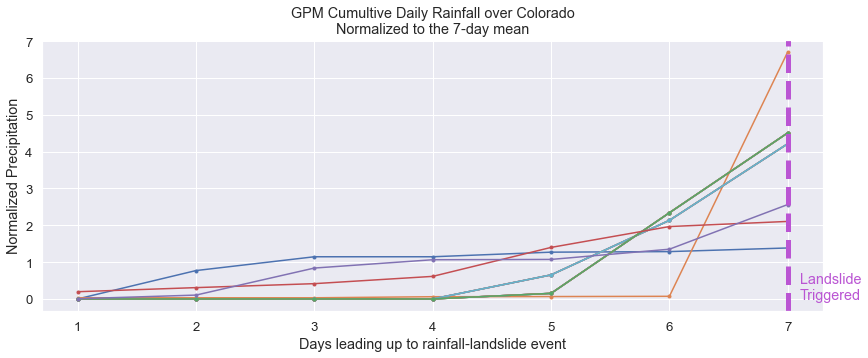

In [11]:
# plot
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in imerge_7day_df.groupby("id"):
    ax.plot(df['days-to-landslide'], 
            df['precip_accum_mm']/df['precip_accum_mm'].mean(), 
            marker='.')

#ax.invert_xaxis()
ax.axvline(x=7, ymin=0, color='mediumorchid', linestyle='dashed', linewidth=5)

ax.set(xlabel='Days leading up to rainfall-landslide event',
       ylabel='Normalized Precipitation',
       title='GPM Cumultive Daily Rainfall over '+state+'\nNormalized to the 7-day mean')
ax.text(7.1 ,0, 'Landslide\nTriggered', color='mediumorchid', fontsize='medium');

#output the figure
output_precip = os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'gpm_precip7d_normalized_timeseries_'+state+'.png')


In [12]:
glc_co_gt2015

,OBJECTID,Shape,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,...,longitude,country_name,country_code,admin_division_name,gazetteer_closest_point,gazetteer_distance,submitted_date,last_edited_date,gpm_imerge_hires_sum,gpm_imerge_hires_max
date,,,,,,,,,,,,,,,,,,,,,
2015-04-27,7986415,"(-106.83929999999998, 40.480200000000025)",Steamboat Today,http://www.steamboattoday.com/news/2015/jun/12...,6994,2015-04-27 00:00:00,NaN,Howelsen Hill,The work will involve repositioning the chairl...,Howelsen Hill,...,-106.839300,United States,US,Colorado,Steamboat Springs,1.11,2016-03-24 17:17:49,2022-04-23 06:42:31,0.000000,0.000000
2015-05-11,7993881,"(-105.22739999999999, 39.77900000000005)",ABC7,http://www.thedenverchannel.com/news/local-new...,7047,2015-05-11 00:00:00,NaN,"Wyoming Circle, Golden",The soil on North Table Mountain is so saturat...,"Wyoming Circle, Golden",...,-105.227400,United States,US,Colorado,Golden,2.78,2015-07-02 14:21:58.000001,2022-04-23 06:23:19,0.000000,0.000000
2015-05-13,7979409,"(-104.83649999999994, 38.921800000000076)",KKTV 11,http://www.kktv.com/home/headlines/Homeowners-...,7060,2015-05-13 00:00:00,NaN,"6250 Fencerail Hts Colorado Springs, CO",The almost nonstop rain last week and over the...,"6250 Fencerail Hts Colorado Springs, CO",...,-104.836500,United States,US,Colorado,Usaf Academy Airstrip,5.73,2015-07-02 18:54:11,2022-04-23 06:37:53,0.000000,0.000000
2015-05-19,7971286,"(-105.09729999999996, 38.55140000000006)",Fox 21 News,http://fox21news.com/2015/05/21/rock-slide-and...,7052,2015-05-19 00:00:00,NaN,Phantom Canyon Road,“Our road crews went further up Phantom Canyon...,Phantom Canyon Road,...,-105.097300,United States,US,Colorado,Fremont County,13.40,2015-07-02 16:21:32,2022-04-23 06:32:24,0.000000,0.000000
2015-05-19,7968089,"(-105.27059999999994, 38.296700000000044)",Wet Mountain Tribune,http://www.wetmountaintribune.com/home.asp?i=8...,7051,2015-05-19 00:00:00,NaN,"Mile Marker 10, Oak Creek Grade Road",A severe mudslide closed Oak Creek Grade on Tu...,"Mile Marker 10, Oak Creek Grade Road",...,-105.270600,United States,US,Colorado,Wetmore,9.17,2015-07-02 16:06:25,2022-04-23 06:30:16,0.000000,0.000000
2015-05-19,7993793,"(-105.09479999999996, 38.55260000000004)",Fox 21 News,http://fox21news.com/2015/05/21/rock-slide-and...,7053,2015-05-19 00:00:00,NaN,Phantom Canyon Road,“Our road crews went further up Phantom Canyon...,Phantom Canyon Road,...,-105.094800,United States,US,Colorado,Fremont County,13.55,2015-07-02 16:23:04,2022-04-23 06:23:19,0.000000,0.000000
2015-05-21,7968172,"(-104.84659999999997, 38.832700000000045)",KKTV 11 News,http://www.kktv.com/home/headlines/Saturated-G...,7048,2015-05-21 00:00:00,NaN,A-1 Mobile Park,According to the Colorado Springs Fire Departm...,A-1 Mobile Park,...,-104.846600,United States,US,Colorado,Colorado Springs,3.05,2015-07-02 15:14:24,2022-04-23 06:30:16,0.000000,0.000000
2015-06-19,7965376,"(-104.85739999999998, 38.77140000000003)",FOX 21 News,http://fox21news.com/2015/06/19/landslide-forc...,6940,2015-06-19 00:00:00,NaN,"Conservation building, Cheyenne Mountain Zoo, ...",The wet weather has been causing some serious ...,"Conservation building, Cheyenne Mountain Zoo, ...",...,-104.857400,United States,US,Colorado,Fort Carson,8.14,2015-06-24 20:42:17,2022-04-23 06:28:10.000001,0.000000,0.000000
2015-07-04,7969119,"(-104.85379999999998, 38.81170000000003)",FOX21,http://fox21news.com/2015/08/17/wet-weekend-we...,7340,2015-07-04 00:00:00,NaN,"Constellation Drive, COLORADO SPRINGS, Colo",A landslide in the neighborhood continued to g...,"Constellation Drive, COLORADO SPRINGS, Colo",...,-104.853800,United States,US,Colorado,Colorado Springs,4.90,2016-05-10 14:26:44,2022-04-23 06:30:59,0.000000,0.000000


In [ ]:
# Below is just playing
# https://stackoverflow.com/questions/59394690/python-pandas-find-matching-values-from-two-dataframes-and-return-third-value

# df3 = glc_co_gt2015.merge(imerge[['id', 'precipitation', 'datetime']],
#                           left_on='event_id',
#                           right_on='id').drop('id',
#                                               axis='columns')
# df4 = df3[['event_id', 'event_date',
#        'admin_division_name', 'latitude',
#        'longitude',
#        'precipitation','datetime']]

In [ ]:
# for id, precip in imerge.groupby('id'):
#     precip.isin()

# imerge.where((imerge['id']==7834)).all()


In [ ]:
# pd.set_option('display.max_rows', None)  # or 1000
# df4[df4['event_id'] == 10312][0:100]